# Compare AE and VAE side-by-side on MNIST

## Install dependencies

In [1]:
from typing import Sequence
from itertools import islice
import subprocess

import jax
import jax.numpy as jnp
import numpy as np

try:
    import tensorflow as tf
except ModuleNotFoundError:
    # flax.training.checkpoints depends on tensorflow,
    # which is only installed by default on Colab
    %pip install -qq tensorflow-cpu
    import tensorflow as tf

tf.config.set_visible_devices([], "GPU")  # prevent TensorFlow from using the GPU

try:
    import flax
except ModuleNotFoundError:
    %pip install -qq flax
    import flax
from flax.training import checkpoints

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    import torchvision.transforms as T
except ModuleNotFoundError:
    %pip install -qq torchvision
    import torchvision.transforms as T
from torchvision.datasets import MNIST

try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch
from torch.utils.data import DataLoader

try:
    import umap.umap_ as umap
except ModuleNotFoundError:
    %pip install -qq umap-learn
    import umap.umap_ as umap

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

     |████████████████████████████████| 197 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 11.0 MB/s 
     |████████████████████████████████| 145 kB 27.2 MB/s 
     |████████████████████████████████| 217 kB 18.5 MB/s 
     |████████████████████████████████| 51 kB 7.6 MB/s 
     |████████████████████████████████| 72 kB 656 kB/s 
     |████████████████████████████████| 88 kB 4.9 MB/s 
     |████████████████████████████████| 1.1 MB 23.7 MB/s 


In [2]:
try:
    from probml_utils.conv_vae_flax_utils import create_train_state, train_step, test_step, decode
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils.conv_vae_flax_utils import create_train_state, train_step, test_step, decode

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 272 kB 10.8 MB/s 
     |████████████████████████████████| 125 kB 74.7 MB/s 


## Create directories

In [3]:
!mkdir /content/ckpts
!mkdir /content/plots

## Download dataset

In [4]:
transform = T.Compose([T.Resize((32, 32)), np.array])

mnist_train = MNIST("/content", train=True, download=True, transform=transform)
mnist_test = MNIST("/content", train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



## Hyperparameters

In [5]:
ckpt_dir = "/content/ckpts"
epochs = 5
batch_size = 256
latent_dim = 20
hidden_channels = (32, 64, 128, 256, 512)
lr = 1e-3
specimen = jnp.empty((32, 32, 1))

configs = {
    "ae": (False, 0),
    "vae_0.1": (True, 0.1),
    "vae_0.5": (True, 0.5),
    "vae_1.0": (True, 1),
}

## Prepare checkpoints

Either by downloading or training

In [6]:
def train(name, variational, beta, loader_train, target_epoch):
    print(f"=== Training {name} ===")
    key = jax.random.PRNGKey(42)
    state = create_train_state(key, variational, beta, latent_dim, hidden_channels, lr, specimen)

    for epoch in range(target_epoch):
        loss_train = 0
        for X, _ in loader_train:
            image = jnp.array(X).reshape((-1, *specimen.shape)) / 255.0
            key, key_Z = jax.random.split(key)
            state, loss = train_step(state, key_Z, image)
            loss_train += loss

        print(f"Epoch {epoch + 1}: train loss {loss_train}")

        # Keep the model with lowest loss_train
        checkpoints.save_checkpoint(
            ckpt_dir, state, epoch + 1, prefix=f"{name}_mnist_", keep=target_epoch, overwrite=True
        )


def prepare_checkpoints(target_epoch, download=True):
    if download:
        # Download pre-trained checkpoints to save time. At the time of writing,
        # we have prepared the checkpoints for the first 5 epochs, so target_epoch
        # must be less than or equal to 5.
        #
        # NOTE: You may want to deletes all existing checkpoints before downloading.
        # print("Deleting existing checkpoints")
        # subprocess.run(["rm", "-rf", ckpt_dir])
        # subprocess.run(["mkdir", ckpt_dir])
        for name in configs:
            url = f"https://internal-use.adroits.xyz/ckpts/mnist_vae_ae_comparison/{name}_mnist_{target_epoch}"
            print("Downloading", url)
            subprocess.run(["wget", "-q", url, "-P", ckpt_dir], check=True)
    else:
        # Alternatively, you can train the model from scratch if you want to tune
        # the hyperparameters. It takes ~9 seconds per epoch per model on a GPU
        # runtime with a Tesla P100 GPU.
        loader_train = DataLoader(mnist_train, batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))

        for name, (variational, beta) in configs.items():
            train(name, variational, beta, loader_train, target_epoch)


prepare_checkpoints(epochs, download=True)

## Load checkpoints

In [7]:
states = {}

for name, (variational, beta) in configs.items():
    key = jax.random.PRNGKey(42)
    state = create_train_state(key, variational, beta, latent_dim, hidden_channels, lr, specimen)
    restored = checkpoints.restore_checkpoint(ckpt_dir, state, prefix=f"{name}_mnist_")
    if state is restored:
        raise FileNotFoundError(f"Cannot load checkpoint from {ckpt_dir}/{name}_mnist_X")
    states[name] = restored

## Visualization of reconstructed images

In [8]:
loader_test = DataLoader(mnist_test, batch_size)
X, y = next(iter(loader_test))
image = jnp.array(X).reshape((-1, *specimen.shape)) / 255.0

recons = {
    "original": image,
}
key = jax.random.PRNGKey(42)
key, *key_Z = jax.random.split(key, 5)
for i, name in enumerate(configs):
    recon, _, _ = test_step(states[name], key_Z[i], image)
    recons[name] = recon

Show a single figure montage

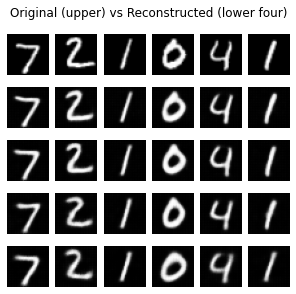

In [9]:
fig, axes = plt.subplots(5, 6, constrained_layout=True, figsize=plt.figaspect(1))
for row, (name, recon) in enumerate(recons.items()):
    for col in range(6):
        axes[row, col].imshow(recon[col].reshape(32, 32), cmap="gray")
        axes[row, col].axis("off")

fig.suptitle("Original (upper) vs Reconstructed (lower four)")
fig.show()
plt.savefig("/content/plots/mnist_recon_montage.pdf")

Plot each row as a separate figure and then save them with meaningful filenames

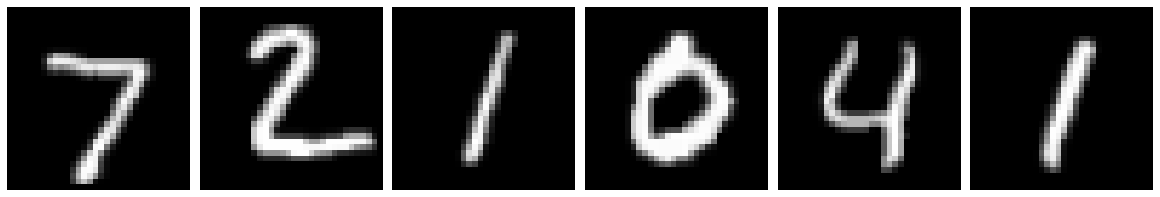

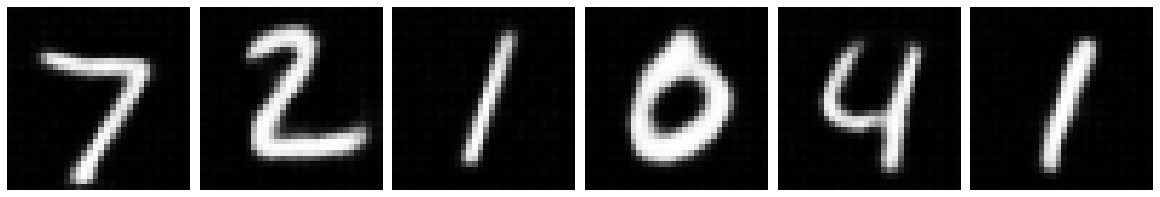

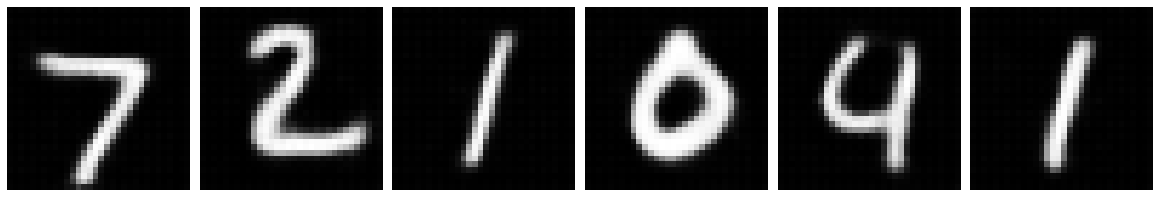

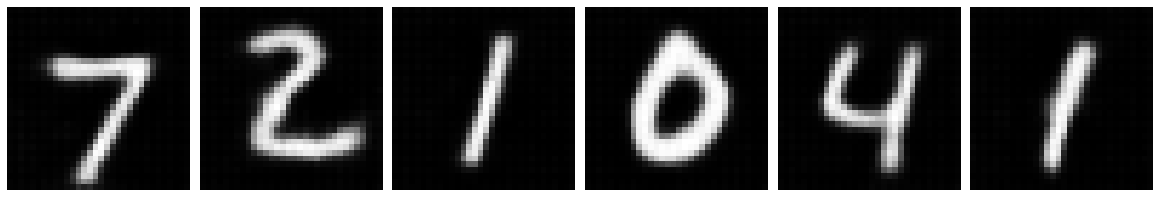

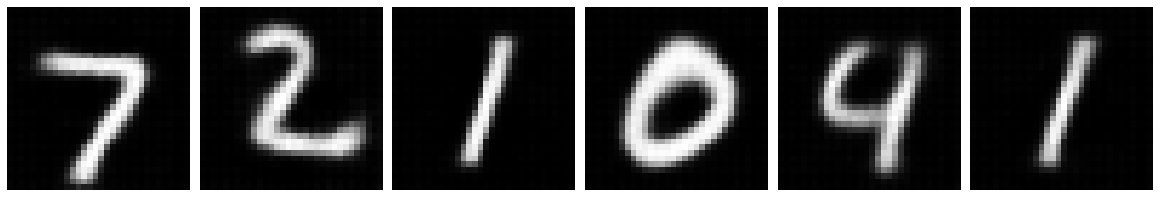

In [10]:
for name, recon in recons.items():
    fig, axes = plt.subplots(1, 6, constrained_layout=True, figsize=plt.figaspect(0.2))
    for col in range(6):
        axes[col].imshow(recon[col].reshape(32, 32), cmap="gray")
        axes[col].axis("off")

    fig.show()
    plt.savefig(f"/content/plots/mnist_recon_{name}.pdf")

## Sampling

In [11]:
key = jax.random.PRNGKey(42)
key, *key_Z = jax.random.split(key, 5)

generated_images = {}
for i, name in enumerate(configs):
    Z = jax.random.normal(key_Z[i], (8, latent_dim))
    generated_image = decode(states[name], Z)
    generated_images[name] = generated_image

Show a single figure montage

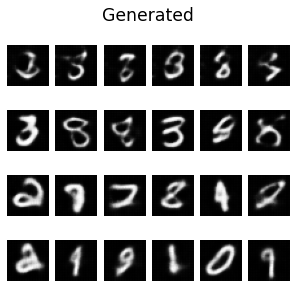

In [12]:
fig, axes = plt.subplots(4, 6, constrained_layout=True, figsize=plt.figaspect(1))
for row, (name, generated_image) in enumerate(generated_images.items()):
    for col in range(6):
        axes[row, col].imshow(generated_image[col].reshape(32, 32), cmap="gray")
        axes[row, col].axis("off")

fig.suptitle("Generated", fontsize="xx-large")
fig.show()
plt.savefig("/content/plots/mnist_gen_montage.pdf")

Plot each row as a separate figure and then save them with meaningful filenames

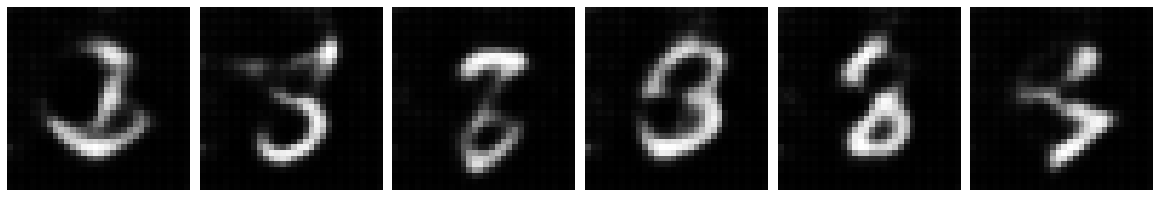

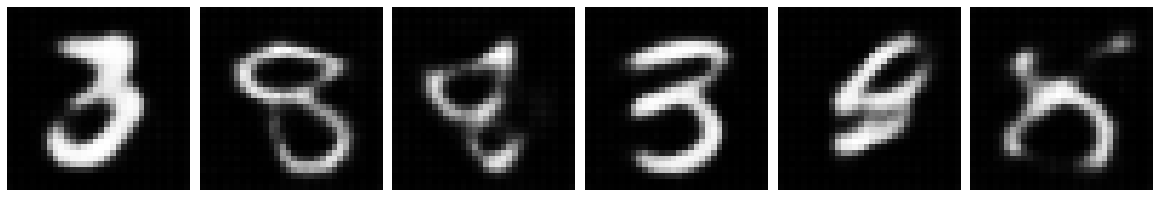

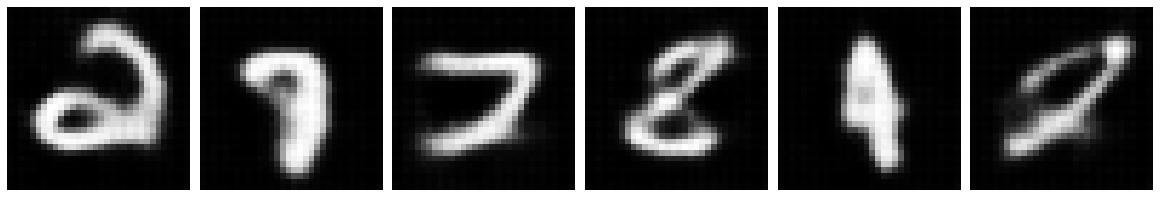

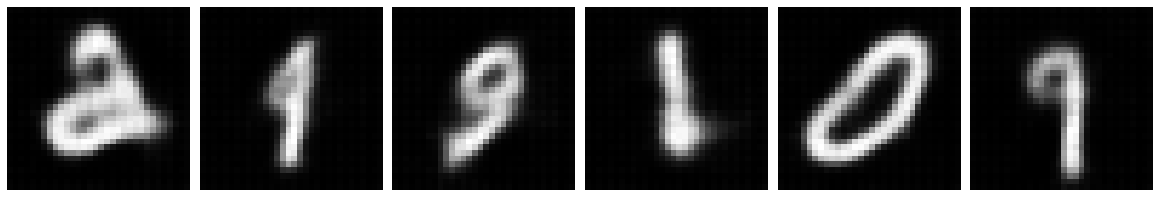

In [13]:
for name, generated_image in generated_images.items():
    fig, axes = plt.subplots(1, 6, constrained_layout=True, figsize=plt.figaspect(0.2))
    for col in range(6):
        axes[col].imshow(generated_image[col].reshape(32, 32), cmap="gray")
        axes[col].axis("off")

    fig.show()
    plt.savefig(f"/content/plots/mnist_gen_{name}.pdf")

## Interpolation

In [14]:
X, y = next(iter(loader_test))
image = jnp.array(X).reshape((-1, *specimen.shape)) / 255.0

means = {}
key = jax.random.PRNGKey(42)
key, *key_Z = jax.random.split(key, 5)
for i, name in enumerate(configs):
    _, mean, _ = test_step(states[name], key_Z[i], image)
    means[name] = mean, image

In [15]:
def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0:
        return low
    elif val >= 1:
        return high
    elif jnp.allclose(low, high):
        return low
    omega = jnp.arccos(jnp.dot(low / jnp.linalg.norm(low), high / jnp.linalg.norm(high)))
    so = jnp.sin(omega)
    return jnp.sin((1.0 - val) * omega) / so * low + jnp.sin(val * omega) / so * high


def interp(start_index, end_index):
    for name, (mean, image) in means.items():
        fig, axes = plt.subplots(1, 6, constrained_layout=True, figsize=plt.figaspect(0.2))

        # Anchors
        axes[0].imshow(image[start_index].reshape(32, 32), cmap="gray")
        axes[0].set_title("Start Image")
        axes[0].axis("off")
        axes[5].imshow(image[end_index].reshape(32, 32), cmap="gray")
        axes[5].set_title("End Image")
        axes[5].axis("off")

        # Interpolated images
        for col in range(1, 5):
            Z = slerp(col / 5, mean[start_index], mean[end_index])
            recon = decode(states[name], Z)
            axes[col].imshow(recon[0].reshape(32, 32), cmap="gray")
            axes[col].set_title(f"{col/5}")
            axes[col].axis("off")

        fig.show()
        plt.savefig(f"/content/plots/mnist_interp_start{start_index}_end{end_index}_{name}.pdf")

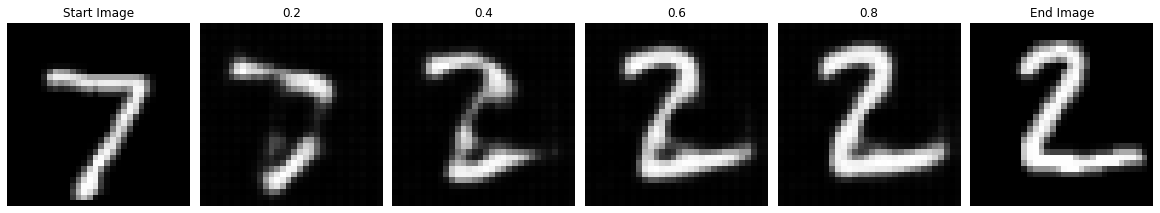

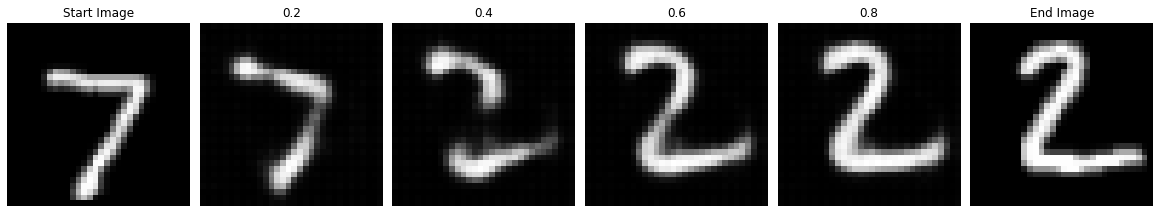

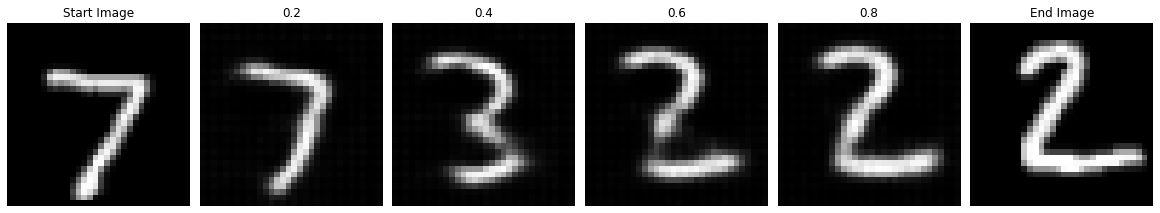

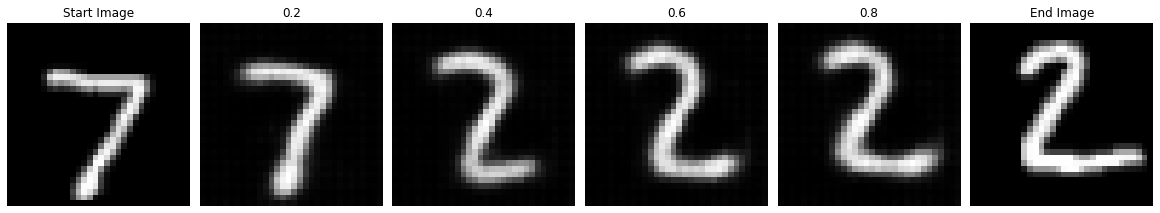

In [16]:
interp(0, 1)

## Visualization of latent space

Calculate latent vectors for all test samples

In [17]:
key = jax.random.PRNGKey(42)
key, *key_Z = jax.random.split(key, 5)

latent = {}
for i, name in enumerate(configs):
    embeddings = []
    for X, _ in loader_test:
        image = jnp.array(X).reshape((-1, *specimen.shape)) / 255.0
        _, embedding, _ = test_step(states[name], key_Z[i], image)
        embeddings.append(embedding)

    embeddings = jnp.concatenate(embeddings)
    latent[name] = embeddings

labels = []
for _, y in loader_test:
    labels.append(jnp.array(y))

labels = jnp.concatenate(labels)

## Visualization with UMAP

Perform UMAP on the embeddings

In [18]:
projections_umap = {}
for name, recon in latent.items():
    reducer = umap.UMAP(random_state=42)
    projections_umap[name] = reducer.fit_transform(latent[name])

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Visualize the clusters

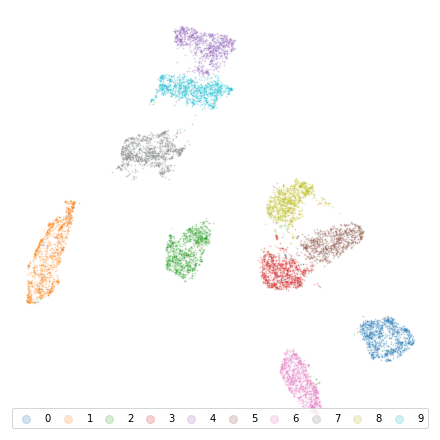

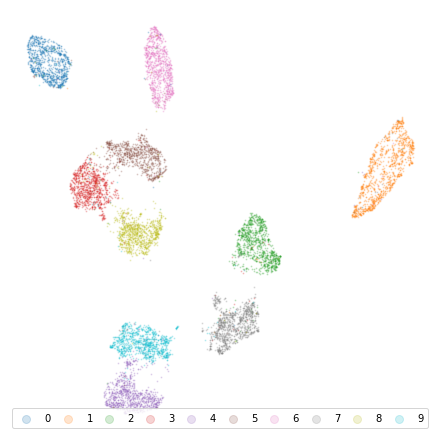

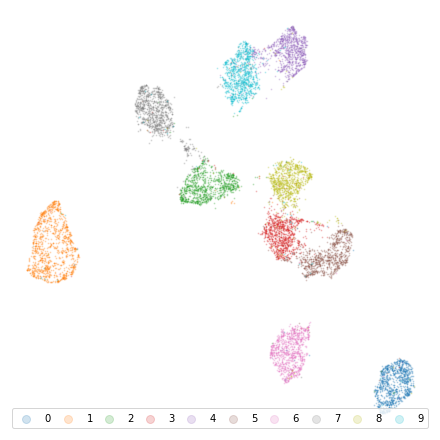

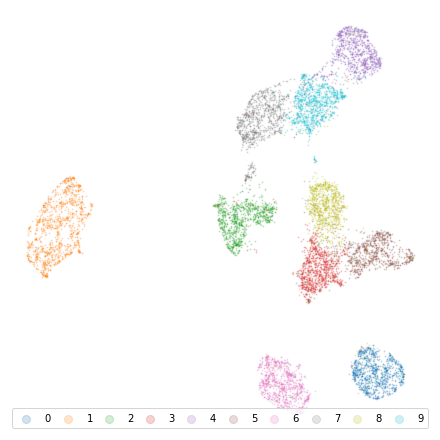

In [19]:
for name, projection in projections_umap.items():
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 6))
    for digit in range(10):
        ax.scatter(
            *projection[labels == digit].T,
            label=f"${digit}$",
            s=1,
            color=plt.cm.tab10(digit),
            edgecolors=None,
            alpha=0.2,
        )

    ax.legend(loc="lower center", ncol=10, mode="expand", markerscale=8)
    ax.axis("off")
    fig.show()
    plt.savefig(f"/content/plots/mnist_latent_umap_{name}.pdf")

## Visualization with t-SNE

Perform t-SNE on the embeddings. Note that it takes ~5 minutes to run.

In [20]:
projections_tsne = {}
for name, recon in latent.items():
    tsne = TSNE(
        init="pca",
        learning_rate="auto",
        random_state=42,
    )
    projections_tsne[name] = tsne.fit_transform(latent[name])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


Visualize the clusters

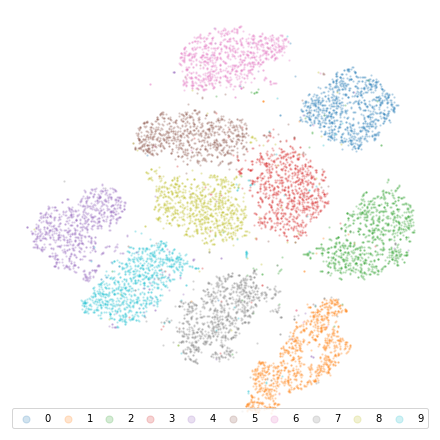

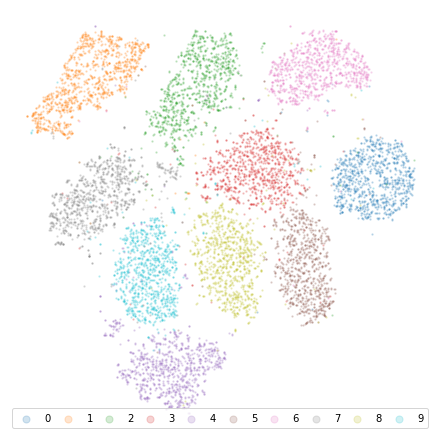

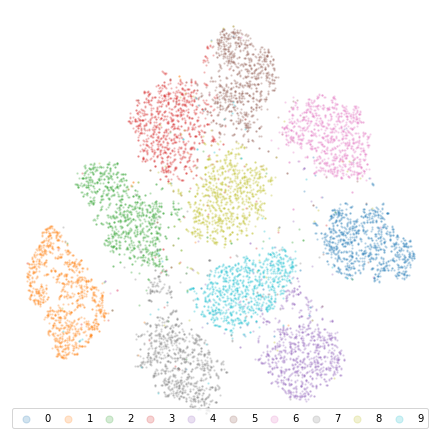

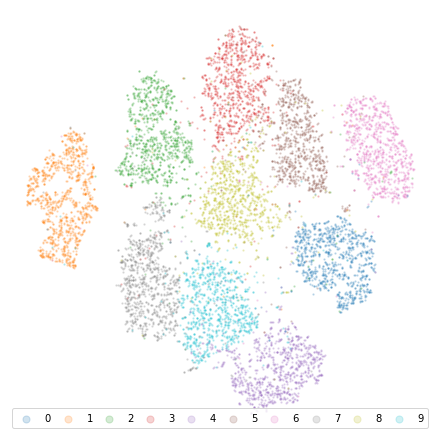

In [21]:
for name, projection in projections_tsne.items():
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 6))
    for digit in range(10):
        ax.scatter(
            *projection[labels == digit].T,
            label=f"${digit}$",
            s=2,
            color=plt.cm.tab10(digit),
            edgecolors=None,
            alpha=0.2,
        )

    ax.legend(loc="lower center", ncol=10, mode="expand", markerscale=5)
    ax.axis("off")
    fig.show()
    plt.savefig(f"/content/plots/mnist_latent_tsne_{name}.pdf")

## Zipping plots for easier download

In [22]:
!zip -q -r /content/plots.zip /content/plots